<a href="https://colab.research.google.com/github/mohitagr18/multimodal_style_coach/blob/main/Style_Coach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pip install --upgrade google-adk

### The 5 Agents on the Team

1.  **Style Coach Agent (The Manager):** The user-facing agent that coordinates the entire team.
2.  **Input Analysis Agent (The Specialist):** An expert in understanding and deconstructing images.
3.  **Trend Research Agent (The Consultant):** Uses Google Search to understand abstract styles and current trends.
4.  **Mercari Search Agent (The Worker):** The retrieval expert that runs targeted searches on the product database.
5.  **Styling & Reasoning Agent (The Creative):** The fashion expert that assembles outfits and explains the style choices.

***



## Full Workflow Example

**Scenario:** A user uploads a photo of a vintage-looking brown leather jacket and asks the `Style Coach Agent`:

> **"I just thrifted this jacket. Can you help me style an outfit around it for a rock concert this fall?"**

---
#### Step 1: The Manager Receives the Request

The **`Style Coach Agent`** receives the combined input (image + text). It knows it can't handle this alone and begins to delegate.

---
#### Step 2: The Specialist Analyzes the Image

The `Style Coach Agent` first needs to understand the core item. It sends the uploaded image to the **`Input Analysis Agent`**.

* **Action:** The `Input Analysis Agent` processes the image using multimodal models.
* **Output:** It returns a structured description back to the manager:
    > `{ "item": "leather jacket", "style": "vintage, bomber", "color": "dark brown" }`

---
#### Step 3: The Consultant Researches the Vibe

Now the `Style Coach Agent` understands the jacket. Next, it needs to understand the *vibe* of a "rock concert this fall." It sends this query to the **`Trend Research Agent`**.

* **Action:** The `Trend Research Agent` uses the **Google Search tool** to find articles and images about current fall concert fashion and rock aesthetics.
* **Output:** It returns a concise summary back to the manager:
    > *"Fall concert style is currently blending 90s grunge with classic rock elements. Key complementary items include vintage band t-shirts, dark wash or black distressed denim, and chunky leather boots like Doc Martens."*

---
#### Step 4: The Worker Finds the Pieces

The `Style Coach Agent` now has a complete shopping list. It commands the **`Mercari Search Agent`** to find the necessary pieces in the product database.

* **Action:** The `Mercari Search Agent` performs several targeted vector searches based on the combined information:
    1.  A search for a visually similar **vintage band t-shirt**.
    2.  A search for **black distressed denim jeans** with text descriptions matching "90s" or "grunge."
    3.  A search for **chunky leather boots** visually similar to Doc Martens.
* **Output:** It returns a list of the top 3-5 matching items for each category.

---
#### Step 5: The Creative Assembles the Look

The `Style Coach Agent` takes the user's original jacket and the pool of items found by the worker and hands it all to the final expert, the **`Styling & Reasoning Agent`**.

* **Action:** This agent uses its advanced LLM capabilities to mix and match the items into a coherent outfit. It selects the best-fitting t-shirt, jeans, and boots to go with the jacket.
* **Output:** It generates a complete, styled look with a detailed explanation:
    > **Look 1: 90s Grunge Rock**
    > * **Your Jacket:** The brown leather jacket is the perfect centerpiece.
    > * **Top:** I've paired it with this faded Nirvana band t-shirt to lean into the 90s grunge theme.
    > * **Bottoms:** These black distressed jeans create a slim silhouette that contrasts well with the bulkier jacket.
    > * **Shoes:** To complete the look, these chunky platform boots give you an authentic rock concert feel and are comfortable enough for standing.

---
#### Step 6: The Manager Presents the Final Result

The `Style Coach Agent` receives the beautifully formatted output from the `Styling & Reasoning Agent` and presents it as the final, polished answer to the user. This completes the workflow.

## Environment Setup

In [16]:
# Import necessary libraries
import os
import logging
import asyncio
import json
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import  InMemorySessionService
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools import google_search
from google.genai import types

# Ignore warnings from ADK and Gemini APIs
logging.getLogger("google.adk.runners").setLevel(logging.ERROR)
logging.getLogger("google_genai.types").setLevel(logging.ERROR)

In [2]:
from google.colab import userdata

# Retrieve the secret key from Colab's secrets manager
my_api_key = userdata.get('GOOGLE_API_KEY')

# Set the environment variable using the retrieved secret
os.environ["GOOGLE_API_KEY"] = my_api_key


# Set environment variables required for running ADK (with Gemini API Key)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "False"



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


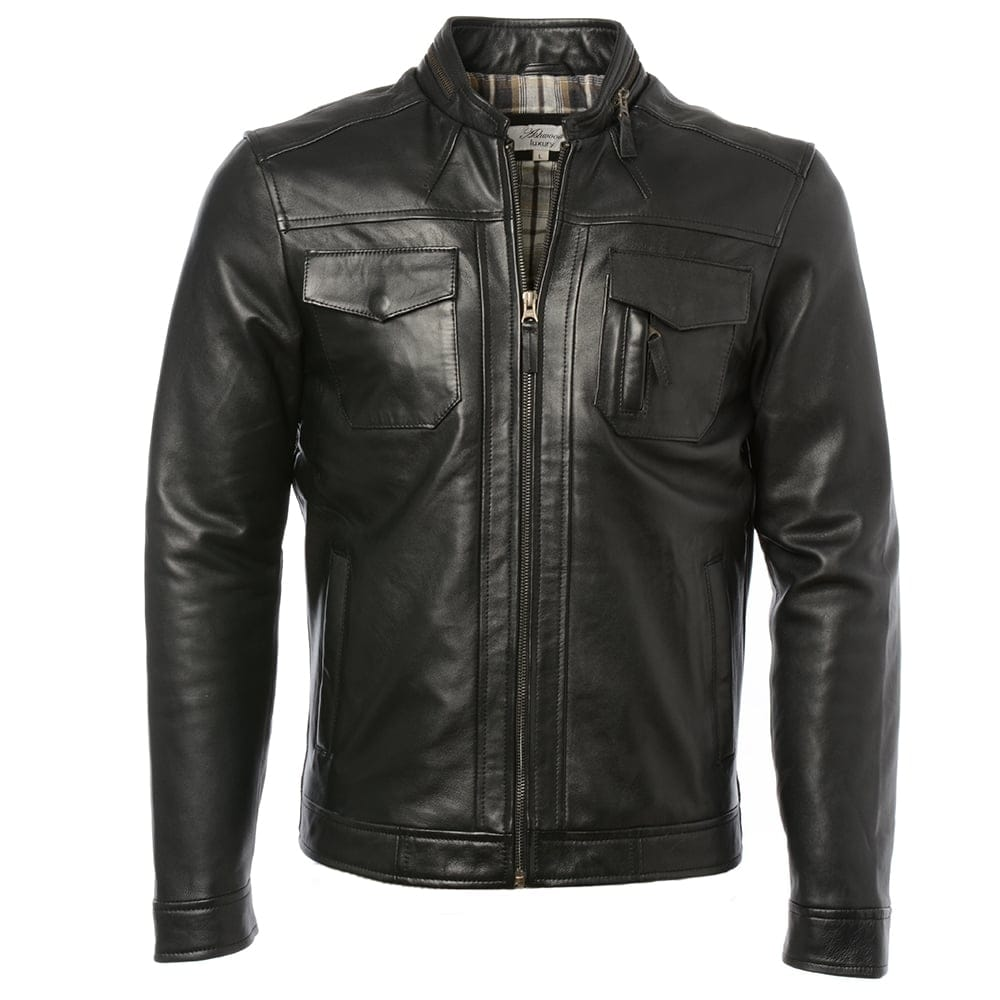

In [4]:
from IPython.display import Image, display

# Define the path to your image in Google Drive
image_path = '/content/drive/My Drive/Colab Notebooks/images/test_img1.jpg'

# Display the image
try:
    display(Image(filename=image_path))
except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
except Exception as e:
    print(f"An error occurred: {e}")

## Create Testing Agent

For testing the agents we will build, we need to define a function test_agent that uses Runner and SessionService to emulate an agent runtime environment. To learn more about the agent runtime, see the Agent Runtime doc.

In [5]:
import pathlib

# Define the app_name and user_id for testing the agents
APP_NAME = "style_coach_app"
USER_ID = "user_1"
session_service = InMemorySessionService()

async def test_agent(
    agent,
    query: str | None = None,
    image_path: str | None = None,
):
    """Sends a text query and/or an image to the agent and prints the response."""

    if not query and not image_path:
        print("Error: Please provide a text query or an image path.")
        return

    # Build a list of parts for the user's message
    parts = []
    log_display = ""
    if query:
        parts.append(types.Part(text=query))
        log_display += f"Query: '{query}'"
    if image_path:
        img = pathlib.Path(image_path)
        if not img.exists():
            print(f"Error: Image file not found at {image_path}")
            return

        # Create an image part from the file path
        image_part = types.Part(
            inline_data=types.Blob(
                mime_type="image/jpeg",  # Or other appropriate mime type
                data=img.read_bytes(),
            )
        )
        parts.append(image_part)
        log_display += f" | Image: '{image_path}'"

    print(f"\n>>> User Input: {log_display.strip()}")

    # Create a session
    session = await session_service.create_session(
      app_name=APP_NAME,
      user_id=USER_ID,
    )

    # Create a Runner
    runner = Runner(
        app_name=APP_NAME,
        agent=agent,
        session_service=session_service,
    )

    # Prepare the user's message with all parts
    content = types.Content(role="user", parts=parts)

    final_response_text = None
    # We iterate through events from run_async to find the final answer.
    async for event in runner.run_async(
        user_id=USER_ID, session_id=session.id, new_message=content
    ):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text
            break
    print(f"<<< Agent Response: {final_response_text}")

| **Agent**                 | **Description**                                                                                                                                                                                          |
|---------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Style Coach Agent         | This is the main, user-facing agent that orchestrates the entire process and manages the conversation. Its role is identical to the original Shop Agent.                                                 |
| Trend Research Agent      | This agent's function is to use an external tool (Google Search) to gather real-world, up-to-date context to better understand a user's vague request.                                                   |
| Input Analysis Agent      | This is a specialized agent required for the Style Coach's advanced multimodal capabilities. Its sole job is to interpret and deconstruct image inputs, which was not a feature of the original example. |
| Mercari Search Agent      | This is a dedicated, more powerful agent responsible for crafting and executing sophisticated vector searches on the product database.                                                                   |
| Styling & Reasoning Agent | This agent adds a crucial reasoning layer that assembles those items into complete, styled outfits and explains why they work together, embodying the "coach" role.                                      |

In [6]:
instruction = f'''
    Your role is a shop search agent on an e-commerce site with millions of
    items. Your responsibility is to search items based on user queries.
'''

shop_agent = Agent(
    model='gemini-2.5-flash',
    name='shop_agent',
    description=(
        'Shop agent for an e-commerce site'
    ),
    instruction=instruction,
)

In [8]:
await test_agent(query="What kind of site is this?", agent=shop_agent)



>>> User Input: Query: 'What kind of site is this?'
<<< Agent Response: This is an e-commerce site, where you can search for and buy various items.


In [11]:
def item_search_tool(query: str) -> str:
    """Searches a secondhand marketplace for clothing items based on a query.

    Args:
        query: A descriptive search query for a clothing item.
               Example: "vintage leather jacket"
    """
    print(f"DEBUG: item_search_tool was called with query: '{query}'")

    # This is our placeholder data, simulating a real database call.
    mock_items = {
        "items": [
            {
                "id": "123",
                "name": "Vintage Distressed Leather Jacket",
                "description": ("A perfect 90s-style leather jacket with a "
                                "worn-in feel. Great for a grunge or rockstar look."),
                "price": "85.00",
                "category": "Outerwear"
            },
            {
                "id": "456",
                "name": "Classic Plaid Mini Skirt",
                "description": ("A red and black plaid skirt. A staple for any "
                                "alternative or preppy wardrobe."),
                "price": "25.00",
                "category": "Skirts"
            }
        ]
    }
    return json.dumps(mock_items)

In [12]:
# Define the core instructions for the agent in a variable.
instruction = f'''
Your role is a friendly and trendy secondhand style coach. Your goal is
to help the user find the perfect secondhand clothing items based on their
request.

You should be encouraging and knowledgeable about fashion. Use your tools
to search for items when necessary and present the results in a helpful,
stylish manner, explaining why an item is a good choice.
'''

# Create the agent instance using the Agent class constructor.
style_coach_agent = Agent(
    model='gemini-1.5-flash',  # Using a modern Gemini model
    name='StyleCoachAgent',
    description=(
        'A conversational agent that acts as a personal stylist for secondhand fashion.'
    ),
    instruction=instruction,
    tools=[item_search_tool]  # Pass the tool function in a list.
)

In [14]:
await test_agent(agent=style_coach_agent,
        query="Can you find a vintage leather jacket for me?")


>>> User Input: Query: 'Can you find a vintage leather jacket for me?'
DEBUG: item_search_tool was called with query: 'vintage leather jacket'
<<< Agent Response: Great! I found a couple of options for you.  Based on your request for a vintage leather jacket, here's what I've got:


**Option 1: Vintage Distressed Leather Jacket**

*   **Price:** $85.00
*   **Description:** This jacket screams 90s grunge and is perfect if you're into that vibe. The distressed look gives it tons of character.  Think effortless cool!

This is a great choice if you want something a little edgy and already broken in.



Because I only have one leather jacket, I'd love to help you refine your search if you'd like. For example, are you looking for a specific color, style (like biker, bomber, etc.), or size?  The more details you can provide, the better I can help you find your perfect match.



## Trend Research Agent

This is a specialized agent whose only job is to understand current fashion trends. When a user asks a broad or style-focused question like, "What's in style for this fall?" or "Help me find a 'cottagecore' outfit," our main agent isn't equipped to answer that directly.

Instead, the StyleCoachAgent will delegate that task to the TrendResearchAgent. This new agent will use **Google Search** to find relevant articles, blog posts, and images to understand the trend. It will then pass a summary or a list of key clothing items back to the main agent.

This multi-agent approach makes our system much smarter and more scalable. Each agent has one job and does it well. 🤖

In [17]:
# 1. Define the instructions for the new agent.
# These are very specific to its single task: research.
research_instruction = f'''
You are a fashion market researcher. Your goal is to use Google Search
to understand the user's fashion-related query.

You must identify the key clothing items, colors, and textures associated
with the user's request. Do not find specific items for sale. Your output
should be a concise summary or a list of descriptive search terms that another
agent can use to find products.

Example user query: "What is cottagecore style?"
Your expected output: "Key items are flowy dresses, puff sleeves,
floral prints, and natural fabrics like cotton and linen. Also look for
cardigans and simple sandals."
'''

# 2. Create the TrendResearchAgent instance.
trend_research_agent = Agent(
    model='gemini-1.5-flash',
    name='TrendResearchAgent',
    description=(
        'Researches fashion trends using Google Search to understand styles, '
        'aesthetics, and key clothing items.'
    ),
    instruction=research_instruction,
    tools=[google_search] # Give the agent access to the Google Search tool.
)

print("✅ TrendResearchAgent has been defined.")
print(f"   - Name: {trend_research_agent.name}")
print(f"   - Tools: {[tool.name for tool in trend_research_agent.tools]}")

✅ TrendResearchAgent has been defined.
   - Name: TrendResearchAgent
   - Tools: ['google_search']
